Q1

PREDICT THE BURNED AREA OF FOREST FIRES WITH NEURAL NETWORKS

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import tensorflow as tf
from sklearn.model_selection import GridSearchCV, KFold
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split, cross_val_score
tf.debugging.set_log_device_placement(False) 
tf.random.set_seed(14)#same result
import keras 
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv('forestfires.csv')
data.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small


In [3]:
df = data.copy()
df.drop(df.columns[11:30],axis=1,inplace = True)
#removing dummies

In [4]:
df.info() #No null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  size_category  517 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 48.6+ KB


In [5]:
df.describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


<AxesSubplot:>

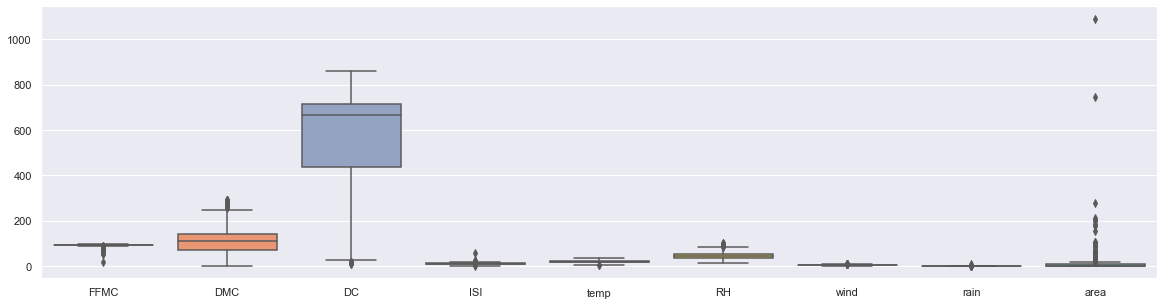

In [6]:
sns.set(rc={'figure.figsize':(20,5)})
sns.boxplot(data=df, orient="v", palette="Set2") 
#outliers exist.

In [7]:
#feature analysis
df.month.value_counts()

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64

In [8]:
df.size_category.value_counts()
#remove bias

small    378
large    139
Name: size_category, dtype: int64

In [9]:
#using label encoding (better than dummy var )


label_encoder = preprocessing.LabelEncoder()
df.month= label_encoder.fit_transform(df.month) 
df.day= label_encoder.fit_transform(df.day) 
df.size_category= label_encoder.fit_transform(df.size_category) 
df.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
0,7,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1
1,10,5,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,1
2,10,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,1
3,7,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1
4,7,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,1


In [10]:
#Removing Bias in the Dataset

In [11]:
resampl = df.copy()
#SMOTEK TECHNIQUE

#Define dataset
a = resampl.iloc[:,:-1]
b = resampl.iloc[:,-1]

#Count before
print(Counter(b))

smt = SMOTETomek(sampling_strategy = 'auto')
a, b = smt.fit_resample(a, b)

#Count after
print(Counter(b)) #removed bias in dataset

Counter({1: 378, 0: 139})
Counter({1: 370, 0: 370})


In [12]:
# Train Split data

In [13]:
X = a
Y = b
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3)

C:\Users\amanu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'T-Sine Visualization of forest-fire dataset')

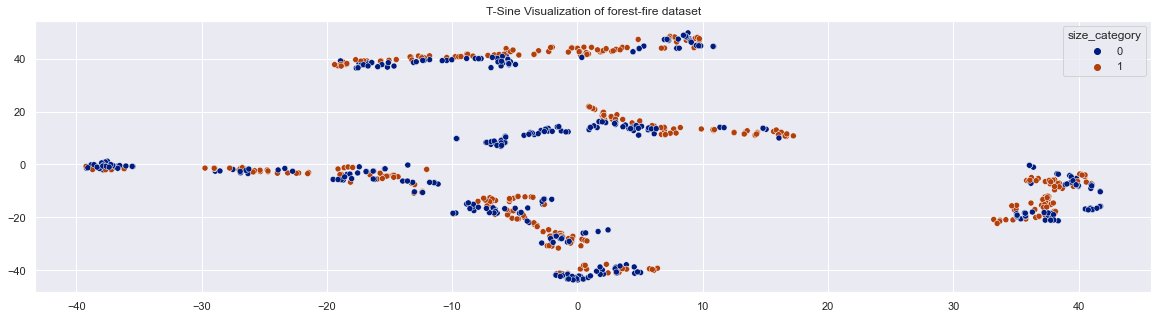

In [14]:
#Data Visualisation
#Visualising the data via dimensionality reduction t-Sine Technique

data_tsne_pca = TSNE(n_components=2).fit_transform(a)
sns.scatterplot(data_tsne_pca[:,0],data_tsne_pca[:,1],hue=b, palette="dark").set_title('T-Sine Visualization of forest-fire dataset')

In [15]:
#neural network model
#model creation
model1 = Sequential()
model1.add(Dense(14, input_dim=11, kernel_initializer='uniform', activation='relu'))
model1.add(Dense(12,kernel_initializer='uniform', activation='relu'))
model1.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

In [16]:
# Compiling model
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
# model fitting
hist1 = model1.fit(X_train, y_train, validation_split=0.33, epochs=30, batch_size=10)
#At epoch 25, our model reached accuracy of 98%, chances of overfitting

Epoch 1/30
35/35 [==============================] - 0s 3ms/step - loss: 0.6909 - accuracy: 0.5677 - val_loss: 0.6875 - val_accuracy: 0.5380
Epoch 2/30
35/35 [==============================] - 0s 658us/step - loss: 0.6814 - accuracy: 0.5821 - val_loss: 0.6735 - val_accuracy: 0.5965
Epoch 3/30
35/35 [==============================] - 0s 629us/step - loss: 0.6538 - accuracy: 0.6859 - val_loss: 0.6495 - val_accuracy: 0.5731
Epoch 4/30
35/35 [==============================] - 0s 658us/step - loss: 0.6159 - accuracy: 0.6916 - val_loss: 0.6024 - val_accuracy: 0.6667
Epoch 5/30
35/35 [==============================] - 0s 686us/step - loss: 0.5486 - accuracy: 0.7550 - val_loss: 0.5242 - val_accuracy: 0.7895
Epoch 6/30
35/35 [==============================] - 0s 686us/step - loss: 0.4492 - accuracy: 0.8184 - val_loss: 0.4339 - val_accuracy: 0.8187
Epoch 7/30
35/35 [==============================] - 0s 658us/step - loss: 0.3515 - accuracy: 0.8847 - val_loss: 0.3929 - val_accuracy: 0.8421
Epoch 8/

In [18]:
model1.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 14)                168       
_________________________________________________________________
dense_1 (Dense)              (None, 12)                180       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


In [19]:
#model evaluation
test_loss, test_acc = model1.evaluate(X_test, y_test)
print(hist1.history.keys())

7/7 [==============================] - 0s 429us/step - loss: 0.0462 - accuracy: 0.9775
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [20]:
hist1_df = pd.DataFrame(hist1.history)
hist1_df["epoch"]=hist1.epoch
hist1_df.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
25,0.067868,0.979827,0.054693,0.976608,25
26,0.040440,0.985591,0.031184,0.994152,26
27,0.032192,0.988473,0.031934,0.994152,27
28,0.026706,0.994236,0.032953,0.994152,28
29,0.024163,0.997118,0.047016,0.976608,29


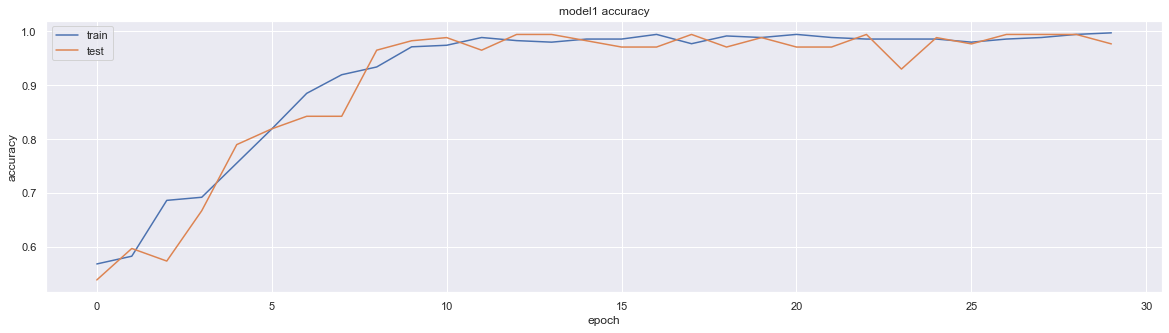

In [21]:
#visualisation of traning history
# accuracy history
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('model1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

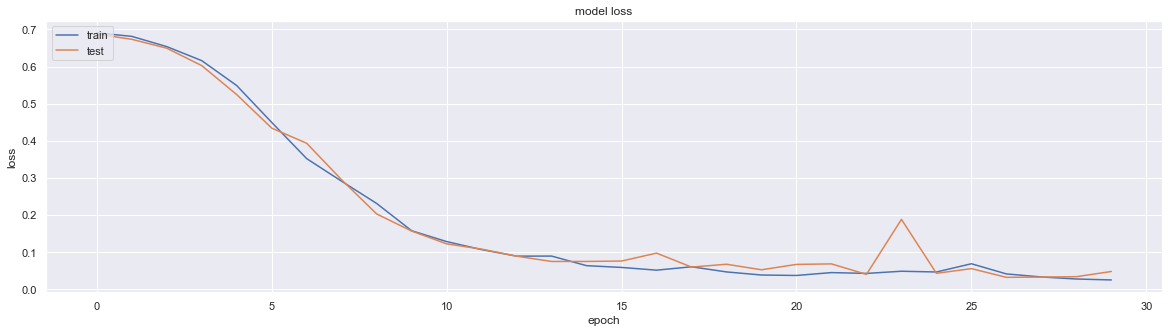

In [22]:
# loss history
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

tuning hyperparmeters

Standardizing X values

In [23]:
a = StandardScaler()
a.fit(X)
X_standardized = a.transform(X)

Tuning set 1 : Batch Size and Epochs

In [24]:
# creating model function
def create_model():
    model = Sequential()
    model.add(Dense(14, input_dim=11, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(12, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    
    adam=Adam(lr=0.01) #learning rate = 0.01
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [25]:
# Creating the model
model = KerasClassifier(build_fn = create_model,verbose = 0)
# Defining the grid search parameters
batch_size = [10,20,40]
epochs = [10,25,50,100]
# Make a dictionary of the grid search parameters
param_grid = dict(batch_size = batch_size,epochs = epochs)
# Build and fit the GridSearchCV
grid = GridSearchCV(estimator = model,param_grid = param_grid,cv = KFold(),verbose = 10)
grid_result = grid.fit(X_standardized,Y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START batch_size=10, epochs=10...................................
[CV 1/5; 1/12] END ....batch_size=10, epochs=10;, score=0.993 total time=   0.4s
[CV 2/5; 1/12] START batch_size=10, epochs=10...................................
[CV 2/5; 1/12] END ....batch_size=10, epochs=10;, score=0.980 total time=   0.6s
[CV 3/5; 1/12] START batch_size=10, epochs=10...................................
[CV 3/5; 1/12] END ....batch_size=10, epochs=10;, score=0.912 total time=   0.4s
[CV 4/5; 1/12] START batch_size=10, epochs=10...................................
[CV 4/5; 1/12] END ....batch_size=10, epochs=10;, score=1.000 total time=   0.4s
[CV 5/5; 1/12] START batch_size=10, epochs=10...................................
[CV 5/5; 1/12] END ....batch_size=10, epochs=10;, score=0.973 total time=   0.5s
[CV 1/5; 2/12] START batch_size=10, epochs=25...................................
[CV 1/5; 2/12] END ....batch_size=10, epochs=25;

[CV 1/5; 11/12] END ...batch_size=40, epochs=50;, score=0.993 total time=   0.5s
[CV 2/5; 11/12] START batch_size=40, epochs=50..................................
[CV 2/5; 11/12] END ...batch_size=40, epochs=50;, score=0.980 total time=   0.7s
[CV 3/5; 11/12] START batch_size=40, epochs=50..................................
[CV 3/5; 11/12] END ...batch_size=40, epochs=50;, score=0.973 total time=   0.5s
[CV 4/5; 11/12] START batch_size=40, epochs=50..................................
[CV 4/5; 11/12] END ...batch_size=40, epochs=50;, score=0.973 total time=   0.5s
[CV 5/5; 11/12] START batch_size=40, epochs=50..................................
[CV 5/5; 11/12] END ...batch_size=40, epochs=50;, score=1.000 total time=   0.5s
[CV 1/5; 12/12] START batch_size=40, epochs=100.................................
[CV 1/5; 12/12] END ..batch_size=40, epochs=100;, score=1.000 total time=   0.9s
[CV 2/5; 12/12] START batch_size=40, epochs=100.................................
[CV 2/5; 12/12] END ..batch_

In [26]:
# Summarizing the results
print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print('{},{} with: {}'.format(mean, stdev, param))
#the best batch size is 20 and epochs is 50

Best : 0.987837839126587, using {'batch_size': 40, 'epochs': 100}
0.9716216206550599,0.031227608705480133 with: {'batch_size': 10, 'epochs': 10}
0.9783783674240112,0.021108776431317436 with: {'batch_size': 10, 'epochs': 25}
0.9810810685157776,0.012385321928420623 with: {'batch_size': 10, 'epochs': 50}
0.9864864826202393,0.014173089778104697 with: {'batch_size': 10, 'epochs': 100}
0.9743243217468261,0.025063840685338817 with: {'batch_size': 20, 'epochs': 10}
0.9770270109176635,0.018429977392354583 with: {'batch_size': 20, 'epochs': 25}
0.983783769607544,0.011780795463914032 with: {'batch_size': 20, 'epochs': 50}
0.9770270109176635,0.018429977392354583 with: {'batch_size': 20, 'epochs': 100}
0.9608108043670655,0.02469684546372951 with: {'batch_size': 40, 'epochs': 10}
0.9675675630569458,0.025063823331537255 with: {'batch_size': 40, 'epochs': 25}
0.9837837815284729,0.010978420798160192 with: {'batch_size': 40, 'epochs': 50}
0.987837839126587,0.01238532973250462 with: {'batch_size': 40, 'e

Tuning set 2 : Learning Rate and Dropout Rate

In [27]:
# Defining the model

def create_model2(learning_rate,dropout_rate):
    model = Sequential()
    model.add(Dense(14,input_dim = 11,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(12,input_dim = 14,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,kernel_initializer='uniform',activation = 'sigmoid'))
    
    adam = Adam(lr = learning_rate)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

# model

model2 = KerasClassifier(build_fn = create_model2,verbose = 0,batch_size = 20,epochs = 50)

# Define the grid search parameters

learning_rate = [0.001,0.01,0.1]
dropout_rate = [0.0,0.1,0.2]

# Make a dictionary of the grid search parameters

param_grids2 = dict(learning_rate = learning_rate,dropout_rate = dropout_rate)

# Build and fit the GridSearchCV

grid2 = GridSearchCV(estimator = model2,param_grid = param_grids2,cv = KFold(),verbose = 10)
grid_result2 = grid2.fit(X_standardized,Y)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 1/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.993 total time=   0.8s
[CV 2/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 2/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.986 total time=   0.8s
[CV 3/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 3/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.973 total time=   0.8s
[CV 4/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 4/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.986 total time=   0.9s
[CV 5/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 5/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.986 total time=   0.8s
[CV 1/5; 2/9] START dropout_rate=0.0, learning_rate=0.01........................
[CV 1/5; 

In [28]:
# Summarizing the results
print('Best : {}, using {}'.format(grid_result2.best_score_,grid_result2.best_params_))
means2 = grid_result2.cv_results_['mean_test_score']
stds2 = grid_result2.cv_results_['std_test_score']
params2 = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means2, stds2, params2):
  print('{},{} with: {}'.format(mean, stdev, param))
#Best score for Dropout rate = 0.2 and learning rate is 0.001

Best : 0.987837839126587, using {'dropout_rate': 0.2, 'learning_rate': 0.001}
0.9851351380348206,0.006620231302048998 with: {'dropout_rate': 0.0, 'learning_rate': 0.001}
0.983783769607544,0.014554497444570358 with: {'dropout_rate': 0.0, 'learning_rate': 0.01}
0.9743243217468261,0.028474744964256667 with: {'dropout_rate': 0.0, 'learning_rate': 0.1}
0.9878378272056579,0.011624762488609932 with: {'dropout_rate': 0.1, 'learning_rate': 0.001}
0.9851351261138916,0.017825547908365203 with: {'dropout_rate': 0.1, 'learning_rate': 0.01}
0.9486486434936523,0.03434665630301148 with: {'dropout_rate': 0.1, 'learning_rate': 0.1}
0.987837839126587,0.015048000681061043 with: {'dropout_rate': 0.2, 'learning_rate': 0.001}
0.9810810804367065,0.011624751402371191 with: {'dropout_rate': 0.2, 'learning_rate': 0.01}
0.9594594597816467,0.027027034759526742 with: {'dropout_rate': 0.2, 'learning_rate': 0.1}


Tuning set 3 : Activation Function and Kernel Initializer

In [29]:
# Defining the model

def create_model3(activation_function,init):
    model = Sequential()
    model.add(Dense(14,input_dim = 11,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(0.2))
    model.add(Dense(12,input_dim = 14,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

# model

model3 = KerasClassifier(build_fn = create_model3,verbose = 0,batch_size = 20,epochs = 50)

# Define the grid search parameters
activation_function = ['softmax','relu','tanh','linear']
init = ['uniform','normal','zero']

# Make a dictionary of the grid search parameters
param_grids3 = dict(activation_function = activation_function,init = init)

# Build and fit the GridSearchCV

grid3 = GridSearchCV(estimator = model3,param_grid = param_grids3,cv = KFold(),verbose = 10)
grid_result3 = grid3.fit(X_standardized,Y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 1/5; 1/12] END activation_function=softmax, init=uniform;, score=0.014 total time=   0.8s
[CV 2/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 2/5; 1/12] END activation_function=softmax, init=uniform;, score=0.757 total time=   1.0s
[CV 3/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 3/5; 1/12] END activation_function=softmax, init=uniform;, score=0.459 total time=   0.8s
[CV 4/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 4/5; 1/12] END activation_function=softmax, init=uniform;, score=0.561 total time=   0.8s
[CV 5/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 5/5; 1/12] END activation_function=softmax, init=uniform;, score=0.101 total time=   0.8s
[CV 1/5; 2/12] START activation_function=softmax, init=normal...

[CV 3/5; 10/12] END activation_function=linear, init=uniform;, score=0.973 total time=   0.7s
[CV 4/5; 10/12] START activation_function=linear, init=uniform..................
[CV 4/5; 10/12] END activation_function=linear, init=uniform;, score=1.000 total time=   1.1s
[CV 5/5; 10/12] START activation_function=linear, init=uniform..................
[CV 5/5; 10/12] END activation_function=linear, init=uniform;, score=1.000 total time=   0.8s
[CV 1/5; 11/12] START activation_function=linear, init=normal...................
[CV 1/5; 11/12] END activation_function=linear, init=normal;, score=1.000 total time=   0.8s
[CV 2/5; 11/12] START activation_function=linear, init=normal...................
[CV 2/5; 11/12] END activation_function=linear, init=normal;, score=1.000 total time=   0.8s
[CV 3/5; 11/12] START activation_function=linear, init=normal...................
[CV 3/5; 11/12] END activation_function=linear, init=normal;, score=0.980 total time=   0.8s
[CV 4/5; 11/12] START activation_f

In [30]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result3.best_score_,grid_result3.best_params_))
means3 = grid_result3.cv_results_['mean_test_score']
stds3 = grid_result3.cv_results_['std_test_score']
params3 = grid_result3.cv_results_['params']
for mean, stdev, param in zip(means3, stds3, params3):
  print('{},{} with: {}'.format(mean, stdev, param))
#best activation function in our case would be Relu and Kernel, Initializer is Uniform

Best : 0.9945945978164673, using {'activation_function': 'tanh', 'init': 'uniform'}
0.3783783810213208,0.2803199211973711 with: {'activation_function': 'softmax', 'init': 'uniform'}
0.37972973585128783,0.27119436802060065 with: {'activation_function': 'softmax', 'init': 'normal'}
0.38243243768811225,0.2707967898333728 with: {'activation_function': 'softmax', 'init': 'zero'}
0.9905405402183532,0.010112579911255349 with: {'activation_function': 'relu', 'init': 'uniform'}
0.9851351380348206,0.010810814797879806 with: {'activation_function': 'relu', 'init': 'normal'}
0.20270270109176636,0.18612381548845214 with: {'activation_function': 'relu', 'init': 'zero'}
0.9945945978164673,0.010810804367065429 with: {'activation_function': 'tanh', 'init': 'uniform'}
0.9945945978164673,0.010810804367065429 with: {'activation_function': 'tanh', 'init': 'normal'}
0.20270270109176636,0.18612381548845214 with: {'activation_function': 'tanh', 'init': 'zero'}
0.9945945978164673,0.010810804367065429 with: {'a

Tuning Set 4: Number of neurons in activation layer

In [31]:
# Defining the model

def create_model4(neuron1,neuron2):
    model = Sequential()
    model.add(Dense(neuron1,input_dim = 11,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(neuron2,input_dim = neuron1,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

# model

model4 = KerasClassifier(build_fn = create_model4,verbose = 0,batch_size = 20,epochs = 50)

# Define the grid search parameters

neuron1 = [4,8,14]
neuron2 = [4,8,12]

# Make a dictionary of the grid search parameters

param_grids4 = dict(neuron1 = neuron1,neuron2 = neuron2)

# Build and fit the GridSearchCV

grid4 = GridSearchCV(estimator = model4,param_grid = param_grids4,cv = KFold(),verbose = 10)
grid_result4 = grid4.fit(X_standardized,Y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 1/5; 1/9] END .........neuron1=4, neuron2=4;, score=1.000 total time=   1.0s
[CV 2/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 2/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.993 total time=   0.8s
[CV 3/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 3/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.939 total time=   0.7s
[CV 4/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 4/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.993 total time=   0.7s
[CV 5/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 5/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.926 total time=   0.7s
[CV 1/5; 2/9] START neuron1=4, neuron2=8........................................
[CV 1/5; 2/9] END .........neuron1=4, neuron2=8;,

In [32]:
# Summarizing the results
print('Best : {}, using {}'.format(grid_result4.best_score_,grid_result4.best_params_))
means4 = grid_result4.cv_results_['mean_test_score']
stds4 = grid_result4.cv_results_['std_test_score']
params4 = grid_result4.cv_results_['params']
for mean, stdev, param in zip(means4, stds4, params4):
  print('{},{} with: {}'.format(mean, stdev, param))

#Best results are Neuron 1 = 4 and Neuron 2 = 4

Best : 0.991891884803772, using {'neuron1': 14, 'neuron2': 8}
0.9702702641487122,0.03128603269924496 with: {'neuron1': 4, 'neuron2': 4}
0.9824324250221252,0.0068905581274034435 with: {'neuron1': 4, 'neuron2': 8}
0.9864864706993103,0.00854670070893039 with: {'neuron1': 4, 'neuron2': 12}
0.9878378272056579,0.013101840709125814 with: {'neuron1': 8, 'neuron2': 4}
0.9905405402183532,0.008108111222589911 with: {'neuron1': 8, 'neuron2': 8}
0.9905405402183532,0.013240488154254468 with: {'neuron1': 8, 'neuron2': 12}
0.9864864826202393,0.012820049492672757 with: {'neuron1': 14, 'neuron2': 4}
0.991891884803772,0.013101840709125814 with: {'neuron1': 14, 'neuron2': 8}
0.9891891837120056,0.012531918414473535 with: {'neuron1': 14, 'neuron2': 12}


Tuning set 5: Trying all HyperParameters at once

In [35]:
'''def create_model5(learning_rate,dropout_rate,activation_function,init,neuron1,neuron2):
    model = Sequential()
    model.add(Dense(neuron1,input_dim = 11,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neuron2,input_dim = neuron1,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = learning_rate)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

# Create the model

#model5 = KerasClassifier(build_fn = create_model5,verbose = 0)

# Define the grid search parameters

batch_size = [10,20,40]
epochs = [10,50,100]
learning_rate = [0.001,0.01,0.1]
dropout_rate = [0.0,0.1,0.2]
activation_function = ['relu','tanh','linear'] #removing softmax since it is for multiclass
init = ['uniform','normal']
neuron1 = [4,8,16]
neuron2 = [2,4,8]

# Make a dictionary of the grid search parameters

param_grids5 = dict(batch_size = batch_size,epochs = epochs,learning_rate = learning_rate,dropout_rate = dropout_rate,
                   activation_function = activation_function,init = init,neuron1 = neuron1,neuron2 = neuron2)

# Build and fit the GridSearchCV

grid5 = GridSearchCV(estimator = model5,param_grid = param_grids5,cv = KFold(),verbose = 10)
grid_result5 = grid5.fit(X_standardized,Y)
'''
#This step will take alot of time so skipping

"def create_model5(learning_rate,dropout_rate,activation_function,init,neuron1,neuron2):\n    model = Sequential()\n    model.add(Dense(neuron1,input_dim = 11,kernel_initializer = init,activation = activation_function))\n    model.add(Dropout(dropout_rate))\n    model.add(Dense(neuron2,input_dim = neuron1,kernel_initializer = init,activation = activation_function))\n    model.add(Dropout(dropout_rate))\n    model.add(Dense(1,activation = 'sigmoid'))\n    \n    adam = Adam(lr = learning_rate)\n    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])\n    return model\n\n# Create the model\n\n#model5 = KerasClassifier(build_fn = create_model5,verbose = 0)\n\n# Define the grid search parameters\n\nbatch_size = [10,20,40]\nepochs = [10,50,100]\nlearning_rate = [0.001,0.01,0.1]\ndropout_rate = [0.0,0.1,0.2]\nactivation_function = ['relu','tanh','linear'] #removing softmax since it is for multiclass\ninit = ['uniform','normal']\nneuron1 = [4,8,16]\nneuron2 = [2

Final Model

In [36]:
# Defining the model

def create_model_fnl():
    model = Sequential()
    model.add(Dense(4,input_dim = 11,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4,input_dim = 4,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001) #sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

In [37]:
# Model creation
model_fnl = KerasClassifier(build_fn = create_model_fnl,verbose = 0,batch_size = 20,epochs = 50)

In [38]:
#train, test data
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_standardized,Y, test_size = 0.3)

In [39]:
# Fitting the model
hist2 = model_fnl.fit(X_train_1,y_train_1)

In [41]:
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix
def report_model(model):
    model_preds = model.predict(X_test_1)
    print(confusion_matrix(y_test_1,model_preds))
    print(classification_report(y_test_1,model_preds))
report_model(model_fnl)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[[105   5]
 [  0 112]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.98       110
           1       0.96      1.00      0.98       112

    accuracy                           0.98       222
   macro avg       0.98      0.98      0.98       222
weighted avg       0.98      0.98      0.98       222



Q2

The dataset contains 36733 instances of 11 sensor measures aggregated over one hour (by means of average or sum) from a gas turbine. 
The Dataset includes gas turbine parameters (such as Turbine Inlet Temperature and Compressor Discharge pressure) in addition to the ambient variables.



Problem statement: predicting turbine energy yield (TEY) using ambient variables as features.



Attribute Information:

The explanations of sensor measurements and their brief statistics are given below.

Variable (Abbr.) Unit Min Max Mean
Ambient temperature (AT) C â€“6.23 37.10 17.71
Ambient pressure (AP) mbar 985.85 1036.56 1013.07
Ambient humidity (AH) (%) 24.08 100.20 77.87
Air filter difference pressure (AFDP) mbar 2.09 7.61 3.93
Gas turbine exhaust pressure (GTEP) mbar 17.70 40.72 25.56
Turbine inlet temperature (TIT) C 1000.85 1100.89 1081.43
Turbine after temperature (TAT) C 511.04 550.61 546.16
Compressor discharge pressure (CDP) mbar 9.85 15.16 12.06
Turbine energy yield (TEY) MWH 100.02 179.50 133.51
Carbon monoxide (CO) mg/m3 0.00 44.10 2.37
Nitrogen oxides (NOx) mg/m3 25.90 119.91 65.29

In [42]:
data = pd.read_csv("gas_turbines.csv")
data.head() 
#consider only AT AP AH, ignore the rest

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311


In [43]:
df = data.copy() 
df = df.drop(['AFDP','GTEP','TIT','TAT','CDP','CO','NOX'],axis=1)
df.head()

,AT,AP,AH,TEY
0,6.8594,1007.9,96.799,114.70
1,6.7850,1008.4,97.118,114.72
2,6.8977,1008.8,95.939,114.71
3,7.0569,1009.2,95.249,114.72
4,7.3978,1009.7,95.150,114.72


In [44]:
df.info() 
df.describe()
#no null values need to normalize before modelling

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   TEY     15039 non-null  float64
dtypes: float64(4)
memory usage: 470.1 KB


,AT,AP,AH,TEY
count,15039.000000,15039.00000,15039.000000,15039.000000
mean,17.764381,1013.19924,79.124174,134.188464
std,7.574323,6.41076,13.793439,15.829717
min,0.522300,985.85000,30.344000,100.170000
25%,11.408000,1008.90000,69.750000,127.985000
50%,18.186000,1012.80000,82.266000,133.780000
75%,23.862500,1016.90000,90.043500,140.895000
max,34.929000,1034.20000,100.200000,174.610000


<AxesSubplot:>

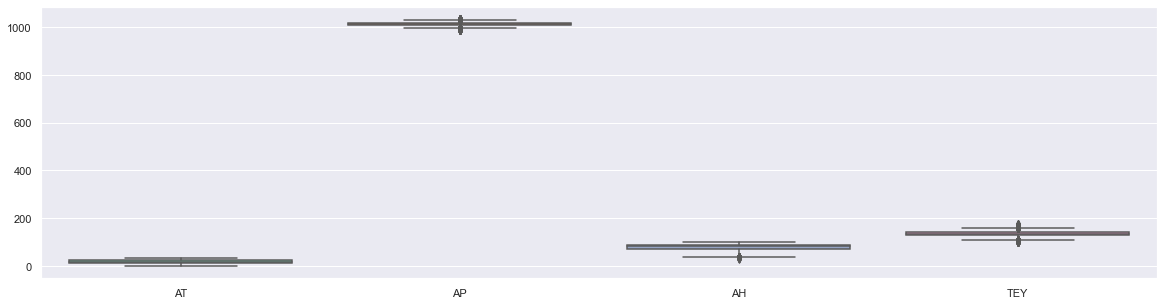

In [45]:
sns.set(rc={'figure.figsize':(20,5)})
sns.boxplot(data=df, orient="v", palette="Set2") 
# no outliers detected but need to standardize the data

Feature Analysis
use all features for building the model

Train | Split dataset
Original Dataset

In [46]:
X =df.iloc[:,:-1]
Y = df.iloc[:,-1]


X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3)

In [47]:
y_train=np.reshape(y_train.to_numpy(), (-1,1))
y_test=np.reshape(y_test.to_numpy(), (-1,1)) 
#one dimensional data in numpy

In [50]:
#using minmax scaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

print(scaler_x.fit(X_train))
xtrain_scale=scaler_x.transform(X_train)

print(scaler_x.fit(X_test))
xtest_scale=scaler_x.transform(X_test)

print(scaler_y.fit(y_train))
ytrain_scale=scaler_y.transform(y_train)

print(scaler_y.fit(y_test))
ytest_scale=scaler_y.transform(y_test)

MinMaxScaler()
MinMaxScaler()
MinMaxScaler()
MinMaxScaler()


In [51]:
len(xtrain_scale)

10527

In [ ]:
#data visualization

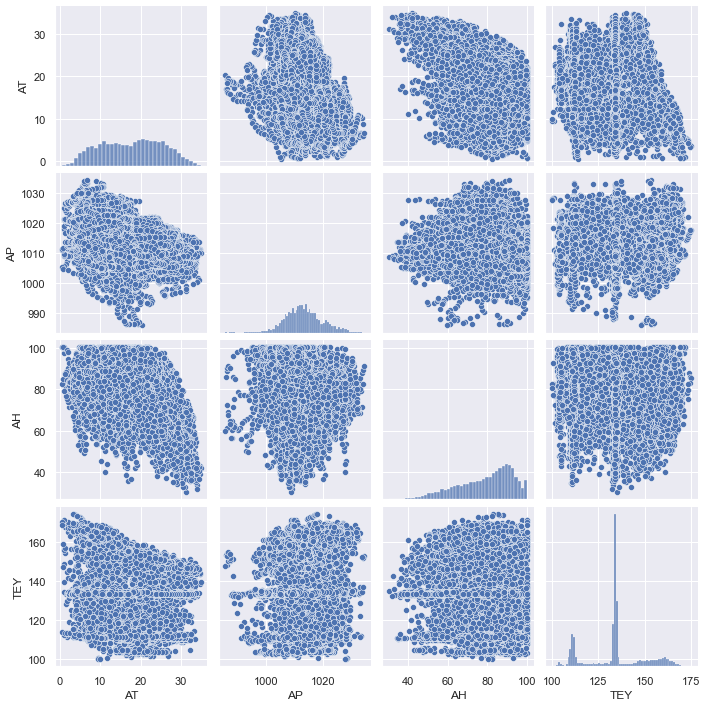

In [54]:
#using pairplot
sns.pairplot(df)

Building the model

In [55]:
model1 = Sequential()
model1.add(Dense(4, input_dim=3, kernel_initializer='normal', activation='relu'))
model1.add(Dense(2106,kernel_initializer='normal', activation='relu'))
model1.add(Dense(1, activation='linear')) #2106 total neurons

In [56]:
# Compile model
model1.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])

In [57]:
# model fitting
hist1 = model1.fit(xtrain_scale, ytrain_scale, validation_split=0.33, epochs=100, batch_size=150)
#At epoch 50, mse and mae just keeps changing

Epoch 1/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0730 - mse: 0.0730 - mae: 0.2084 - val_loss: 0.0483 - val_mse: 0.0483 - val_mae: 0.1598
Epoch 2/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0455 - mse: 0.0455 - mae: 0.1549 - val_loss: 0.0478 - val_mse: 0.0478 - val_mae: 0.1574
Epoch 3/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0448 - mse: 0.0448 - mae: 0.1505 - val_loss: 0.0477 - val_mse: 0.0477 - val_mae: 0.1607
Epoch 4/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0445 - mse: 0.0445 - mae: 0.1507 - val_loss: 0.0477 - val_mse: 0.0477 - val_mae: 0.1629
Epoch 5/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0446 - mse: 0.0446 - mae: 0.1536 - val_loss: 0.0471 - val_mse: 0.0471 - val_mae: 0.1609
Epoch 6/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0440 - mse: 0.0440 - mae: 0.1532 - val_loss: 0.0464 - val_mse: 0.0464 - val_mae: 0.1575
Epoch 7/100
48/48 [==

48/48 [==============================] - 0s 2ms/step - loss: 0.0392 - mse: 0.0392 - mae: 0.1571 - val_loss: 0.0447 - val_mse: 0.0447 - val_mae: 0.1710
Epoch 52/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0396 - mse: 0.0396 - mae: 0.1579 - val_loss: 0.0414 - val_mse: 0.0414 - val_mae: 0.1628
Epoch 53/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0389 - mse: 0.0389 - mae: 0.1562 - val_loss: 0.0416 - val_mse: 0.0416 - val_mae: 0.1630
Epoch 54/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0391 - mse: 0.0391 - mae: 0.1559 - val_loss: 0.0414 - val_mse: 0.0414 - val_mae: 0.1632
Epoch 55/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0389 - mse: 0.0389 - mae: 0.1563 - val_loss: 0.0429 - val_mse: 0.0429 - val_mae: 0.1668
Epoch 56/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0399 - mse: 0.0399 - mae: 0.1595 - val_loss: 0.0409 - val_mse: 0.0409 - val_mae: 0.1616
Epoch 57/100
48/48 [=========

In [58]:
model1.summary() 

Model: "sequential_378"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1134 (Dense)           (None, 4)                 16        
_________________________________________________________________
dense_1135 (Dense)           (None, 2106)              10530     
_________________________________________________________________
dense_1136 (Dense)           (None, 1)                 2107      
Total params: 12,653
Trainable params: 12,653
Non-trainable params: 0
_________________________________________________________________


In [59]:
#model evaluation
y_predict = model1.predict(xtest_scale)

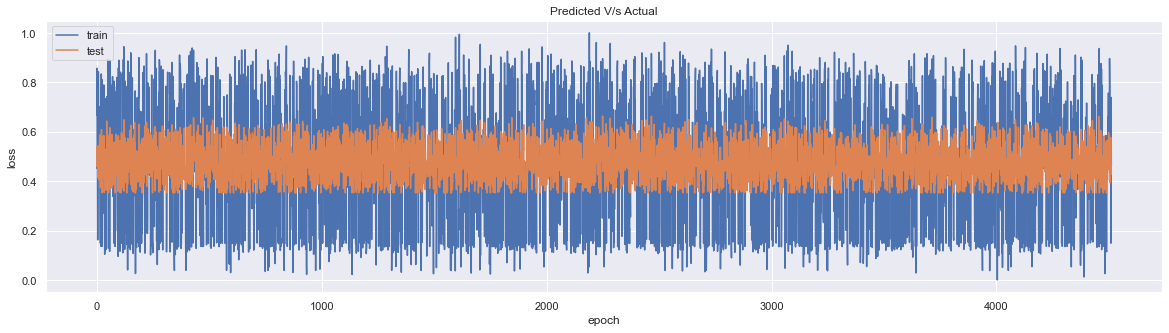

In [60]:
# Comparing of predicted and actual values using plot
plt.plot(ytest_scale)
plt.plot(y_predict)
plt.title('Predicted V/s Actual')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# we got a regression problem and predicting using neural network is not suitable

In [61]:
hist1_df = pd.DataFrame(hist1.history)
hist1_df["epoch"]=hist1.epoch
hist1_df.tail()

,loss,mse,mae,val_loss,val_mse,val_mae,epoch
95,0.038598,0.038598,0.155972,0.040882,0.040882,0.161645,95
96,0.038920,0.038920,0.156592,0.040760,0.040760,0.161792,96
97,0.038687,0.038687,0.155345,0.040791,0.040791,0.162255,97
98,0.038705,0.038705,0.155696,0.042227,0.042227,0.166273,98
99,0.039080,0.039080,0.157475,0.041277,0.041277,0.163179,99
